In [1]:
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

import scipy
import numpy as np

import math

%matplotlib inline
%load_ext line_profiler

#### k-NN affinity matrix

In [269]:
def k_nearest(X, k):
    N, D = X.shape
    
    X = X.astype(np.float32)
    
    if k > N:
        k = N
    
    W = np.zeros((N,N))
    
    for i in range(N):
        for j in range(i, N):
            xi = normalize(X[i].reshape(1, -1)).ravel()
            xj = normalize(X[j].reshape(1, -1)).ravel()
            W[(i,j),(j,i)] = np.inner(xi - xj, xi - xj)
        W[i, np.argsort(W[i])[k+1:]] = 0
    
    return W

def gaus_affinity(X, k, sigma):
    W = k_nearest(X, k)
    W = np.where(W != 0, np.exp(-W/(2*(sigma**2))), 0)
    return W + W.T


## Remi's gaussian affinity
from sklearn.neighbors import NearestNeighbors
def gaussian_knn_affinity(X, k, sqsigma):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute', metric='sqeuclidean').fit(X)
    W = nbrs.kneighbors_graph(X, mode='distance').toarray()
    W[W.nonzero()] = np.exp(- W[W.nonzero()] / (2 * sqsigma))
    W = W + W.T
    return W

## 1. Clustering Algorithms

#### SpectralClustering

In [3]:
def spectralClustering(W, n):
    N, _ = W.shape
    
    D = np.diag(W.dot(np.ones((N,1))).ravel())
    L = D - W
    _, V = np.linalg.eigh(L)

    Y = V[:, :n]
          
    kmeans = KMeans(n_clusters=n, random_state=0).fit(Y)
    
    return kmeans.labels_

#### K-Subspaces

#### unoptimize code

In [353]:
def segment(U, x, mu):
    D, _ = U.shape
    I = np.identity(D)
    
    return np.linalg.norm((I - U.dot(U.T)).dot(x - mu))


#         W = np.zeros((k, N), dtype=np.int8)
        
#         # TODO: improve this part
#         # 3 . segmentation
#         for j in range(N):
            
            
#             idx = 0
#             best_segment = math.inf
#             for i in range(k):
#                 temp = segment(U[:,:,i], X[j], mu[:,i])
#                 if temp <= best_segment:
#                     best_segment = temp
#                     idx = i
#             W[idx,j] = 1  

Still unoptimized code as einsum on tensors takes a long amount of time. See Rémi Lespinet implementation for a fast implementation

In [4]:
def ortho(D, d, k):
    U = np.random.randn(D, d, k)
    
    # normalize
    for i in range(k):
        U[:,:,i] = scipy.linalg.orth(U[:,:,i])
    
    return U


def segment2(U, x, mu):
    D, _, _ = U.shape
    I = np.identity(D)
    
    toto = np.transpose(x[:,:, None]-mu, (0,2,1))
    tata = I - np.einsum('ijk,ljk->kil', U, U)
    guru = np.einsum('ijk,lik->lij', tata, toto)
    ninja = np.einsum('ijk,ijk->ij', guru, guru)

    W = np.where(ninja.T == np.min(ninja, axis=1), 1, 0)
    
    return W  


def kSubspaces(X, k, d, replicates=10):
    N, D = X.shape
    
    projections = np.zeros(replicates)
    bestGroup = np.zeros(replicates)
    I = np.identity(D)
    
    for rep in range(replicates):
        U = ortho(D, d, k)    
        mu = np.random.randn(D, k)

        y = np.zeros((d, N))

        # CHANGE ending condition
        for m in range(100):
            # 3 . segmentation
            W = segment2(U, X, mu)

            # 4. estimation
            for i in range(k):
                if np.sum(W[i,:]) > 0:
                    mu[:,i] = np.sum(np.multiply(W[i,:].reshape(N,1),X), axis=0)/np.sum(W[i,:])
                    center_data = X - mu[:,i]
                    Sigma = np.einsum('ij,ik, i->jk', center_data, center_data, W[i,:])
                    _, U_ = np.linalg.eigh(Sigma)
                    U[:,:, i] = U_[:,:d]

                for j in range(N):
                    if W[i,j] == 1:
                        y[:,j] = U[:,:,i].T.dot(X[j] - mu[:,i])
                
            
                    dist = (I - U[:,:, i].dot(U[:,:, i].T)).dot(X[j] - mu[:,i])
                    projections[rep] += W[i, j] * np.inner(dist, dist)
        bestGroup[rep] = np.argmax(W, axis=1)
    
    return bestGroup[np.argmin(projections)]

#### Sparse Subspace Clustering

In [58]:
# https://arxiv.org/pdf/1203.1005.pdf

def shrinked_thresholding(X, tau):
    return np.sign(X) * np.maximum(np.absolute(X)-tau,0)

def lasso_admm(X, tau, mu, max_iter=300, eps_precision=2e-4):
    D, N = X.shape
    C = np.zeros((N,N))
    delta =np.zeros((N,N))
    I = np.identity(N)
    
    U = np.linalg.inv((tau * X.T.dot(X) + mu * I))
    V = X.T.dot(X)
    
    i = 0
    
    while i < max_iter:
        Z = U.dot(tau * V + mu * (C - delta/mu))
        
        C = shrinked_thresholding(Z + delta/mu, 1/mu)
        
        C = C - np.diag(np.diag(C))
        delta = delta + mu * (Z - C)
        
        if np.linalg.norm(np.absolute(Z-C), np.inf) < eps_precision:
            break
        
        i += 1
    
    return C

def normalized_sc(W, n):
    N, _ = W.shape
    
    # construct G
    D = np.diag(W.dot(np.ones((N,1))).ravel())
    L = D - W
    D12 = np.where(D != 0, (D+1e-16)**(-1/2), D)
    
    _, V = np.linalg.eigh(D12.dot(L.dot(D12)))

    Y = V[:, :n]
    
    kmeans = KMeans(n_clusters=n, random_state=0).fit(Y)
    
    return kmeans.labels_

def ssc(X, k, tau, mu):
    D, N = X.shape
    C = lasso_admm(X, tau, mu)
    
    # normalize the columns using Algorithm 1 from
    # https://arxiv.org/pdf/1203.1005.pdf
    C = C / np.linalg.norm(C, np.inf, axis=0)
    
    W = np.absolute(C) + np.absolute(C).T
    
    group = normalized_sc(W, k)
    return group

#### Sparse Spectral Clustering with outliers

In [254]:
def lasso_admm_corrupt(X, tau, mu1, mu2, max_iter=100, eps_precision=2e-4):
    D, N = X.shape
    C = np.zeros((N, N))
    E = np.zeros((D, N))
    delta1 = np.zeros((D,N))
    delta2 = np.zeros((N,N))
    I = np.identity(N)
    
    U = np.linalg.inv((mu1 * X.T.dot(X) + mu2 * I))
    
    i = 0
    
    while i < max_iter:
        Z = U.dot(mu1 * X.T.dot(X - E + delta1/mu1) + mu2 * (C - delta2/mu2))
        
        C = shrinked_thresholding(Z + delta2/mu2, 1/mu2)
        
        C = C - np.diag(np.diag(C))
        
        E = shrinked_thresholding(X - X.dot(Z) + delta1/mu1, tau/mu2)
        
        delta1 = delta1 + mu1 * (X - X.dot(Z) - E)
        delta2 = delta2 +  mu2 * (Z - C)
        
        print(i, np.linalg.norm(np.absolute(Z-C), np.inf))
        
        if np.linalg.norm(np.absolute(Z-C), np.inf) < eps_precision:
            break
        
        i += 1
    
    return C

def ssc_corrupt(X, k, tau, mu1, mu2, max_iter=100):
    D, N = X.shape
    C = lasso_admm_corrupt(X, tau, mu1, mu2, max_iter=max_iter)
    
    # normalize the columns using Algorithm 1 from
    # https://arxiv.org/pdf/1203.1005.pdf
    C = C / np.linalg.norm(C, np.inf, axis=0)
    
    W = np.absolute(C) + np.absolute(C).T
    
    group = normalized_sc(W, k)
    return group

#### We use relation (14) from https://arxiv.org/pdf/1203.1005.pdf to compute a suitable value of $\tau$

__getTau__ returns the minimal value of $\tau$: $\tau_{min} = \frac{1}{\min\limits_{i} \max\limits_{j \neq i} | y_i^Ty_j|}$

In [276]:
def getTau(X):
    M = np.dot(X, X.T)
    M = M - np.diag(np.diag(M))
    return 1/min(np.max(M, axis = 1))

def getTauCorrupt(X):
    return 1/np.sort(np.linalg.norm(X, axis=1, ord=1))[-2]

#### Clustering error function

In [60]:
from scipy.optimize import linear_sum_assignment

In [61]:
def clustering_error(true_label, pred_label):
    unique_true_label = np.unique(true_label)
    unique_pred_label = np.unique(pred_label)
    
    W = np.zeros((len(unique_true_label), len(unique_pred_label)), dtype=int)

    for k, l in enumerate(unique_true_label):
        idx = np.where(true_label == l)[0]
        values, counts = np.unique(pred_label[idx], return_counts=True)
    
        for i, v in enumerate(values):
            W[k, v] = counts[i]
    
    row_ind, col_ind = linear_sum_assignment(-W)
    _, sorted_col_idx = zip(*sorted(zip(col_ind, row_ind)))
    
    best_match = np.zeros_like(pred_label)
    for i in range(len(unique_pred_label)):
        best_match[pred_label == unique_pred_label[[i]]] = unique_true_label[sorted_col_idx[i]]
    
    # return percentage of error
    return np.sum(true_label != best_match)/len(true_label)

## 2. Face Clustering

In [62]:
import scipy.io

#### load and understand the datas

In [63]:
extendedYaleB = scipy.io.loadmat('ExtendedYaleB.mat')
EYALEB_DATA = extendedYaleB['EYALEB_DATA']
EYALEB_LABEL = extendedYaleB['EYALEB_LABEL']

#### display a single image

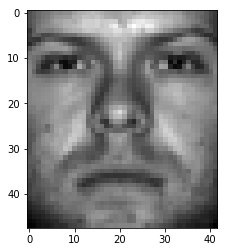

In [64]:
idx = 0
plt.imshow(EYALEB_DATA[:,idx].reshape(42,48).T, cmap='gray')

#### individuals 1-2

In [66]:
mask_ind12, = np.where(np.logical_or(extendedYaleB['EYALEB_LABEL'][0,:] == 1,
              extendedYaleB['EYALEB_LABEL'][0,:] == 2) == True)

In [67]:
ind12_data = extendedYaleB['EYALEB_DATA'][:,mask_ind12].astype(int)
ind12_labels = extendedYaleB['EYALEB_LABEL'][:,mask_ind12].reshape(-1)

#### Spectral Clustering individuals 1-2
Tuning the $k$ and $\sigma$ parameter using __individuals 1-2__ from ExtendedYaleB dataset

In [313]:
# k = 2, sigma = 0.4
Aff = gaus_affinity(ind12_data.T, 2, 0.4)
pred_labels12 = spectralClustering(Aff, 2)
print("clustering error: ", clustering_error(ind12_labels, pred_labels12))

clustering error:  0.0078125


#### fix $\sigma = 1$

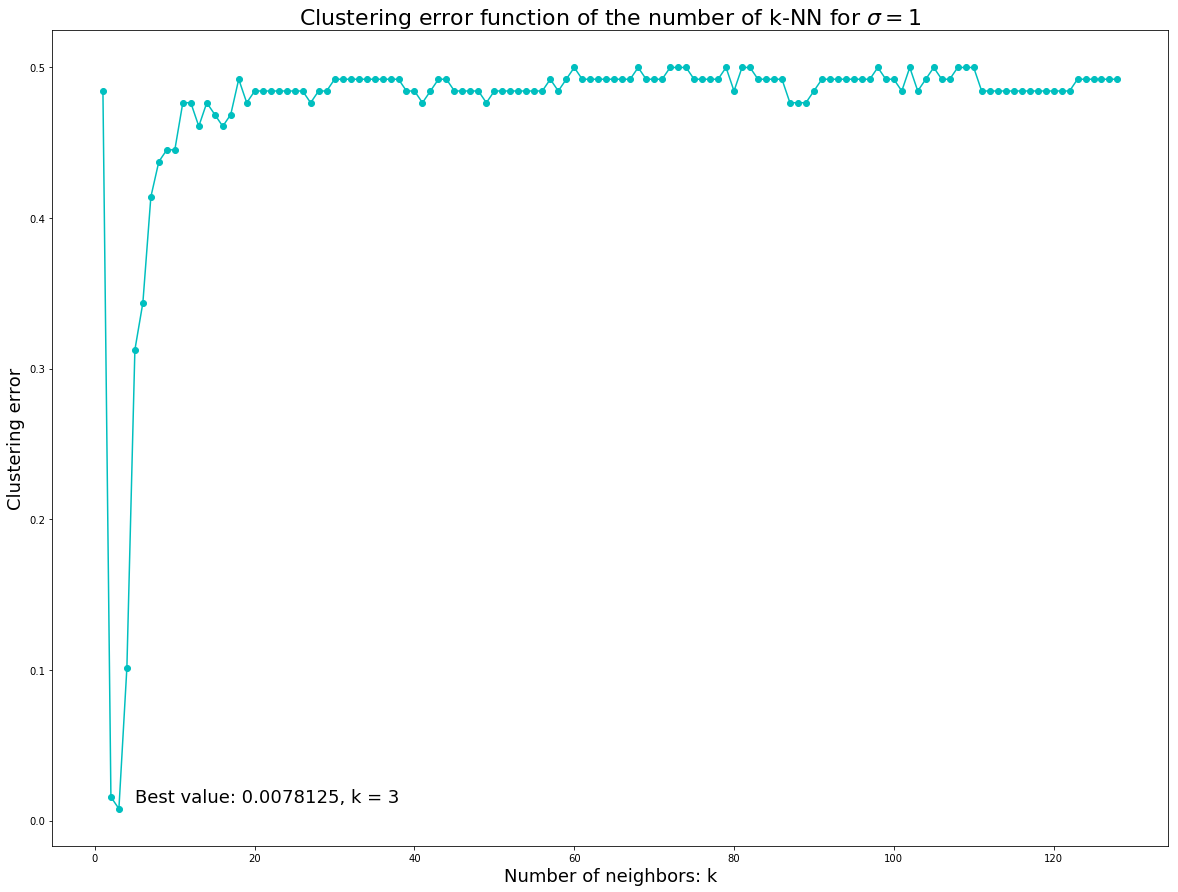

In [103]:
error = []

ks = np.arange(len(ind12_labels)) + 1
for k in ks:
    Aff = gaus_affinity(ind12_data.T, k, 1)
    pred_labels12 = spectralClustering(Aff, 2)
    error.append(clustering_error(ind12_labels, pred_labels12))

plt.figure(figsize=(20,15))
plt.plot(ks, error, '-oc')
plt.xlabel("Number of neighbors: k", size=18)
plt.ylabel("Clustering error", size=18)
plt.title(r'Clustering error function of the number of k-NN for $\sigma = 1$', size=22)
txt = "Best value: {}, k = {}".format(min(error), ks[np.argmin(error)])
plt.text(5,0.012, txt, size=18)

#### Use the best k ($k=3$) and tune $\sigma$ parameter

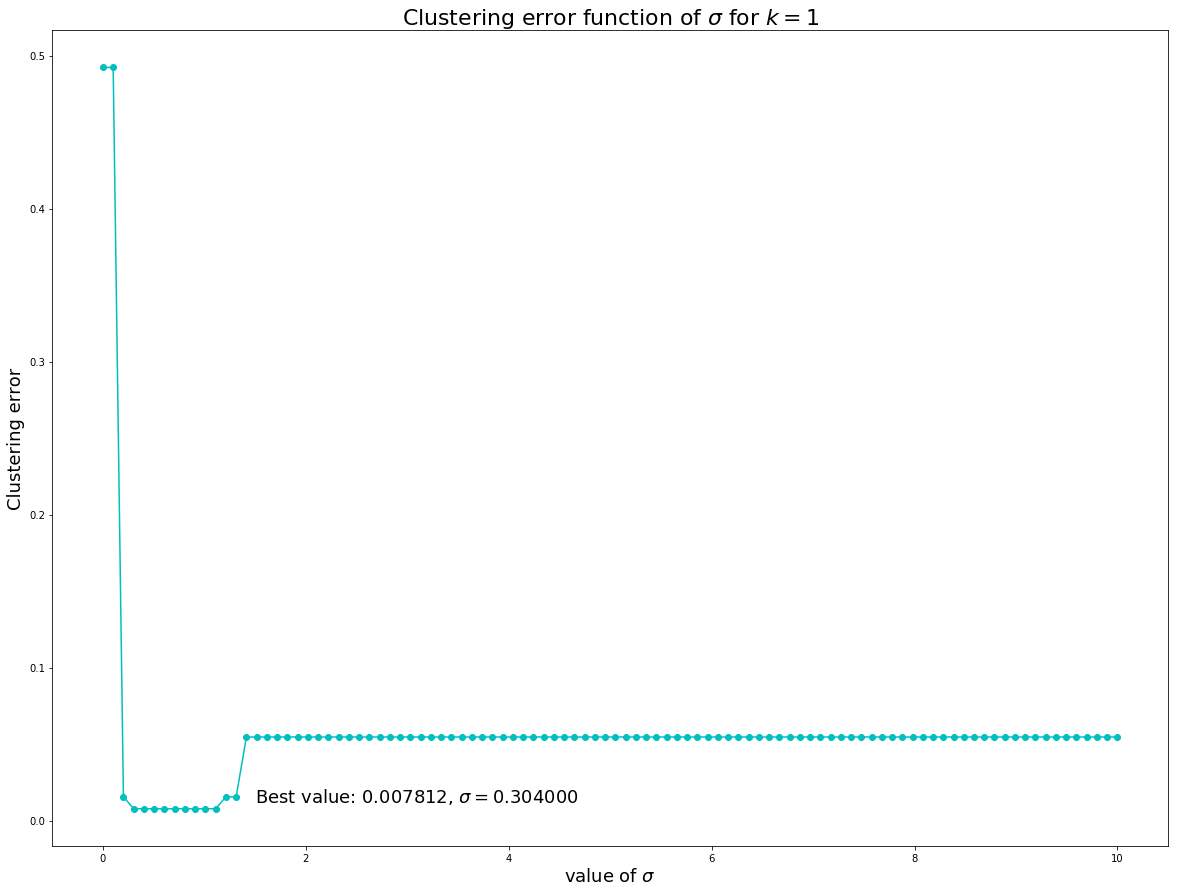

In [120]:
error = []
sigmas = np.linspace(0.001, 10, 100)
for sig in sigmas:
    Aff = gaus_affinity(ind12_data.T, 3, sig)
    pred_labels12 = spectralClustering(Aff, 2)
    error.append(clustering_error(ind12_labels, pred_labels12))

plt.figure(figsize=(20,15))
plt.plot(sigmas, error, '-oc')
plt.xlabel(r'value of $\sigma$', size=18)
plt.ylabel("Clustering error", size=18)
plt.title(r'Clustering error function of $\sigma$ for $k = 1$', size=22)
txt = r'Best value: {:2f}, $\sigma = {:2f}$'.format(min(error), sigmas[np.argmin(error)])
plt.text(1.5,0.012, txt, size=18)

## Spectral Clustering best value: $\sigma = 0.3, k=3$

#### SSC individuals 1-2

In [141]:
tau_min = 10 * getTau(ind12_data.T)

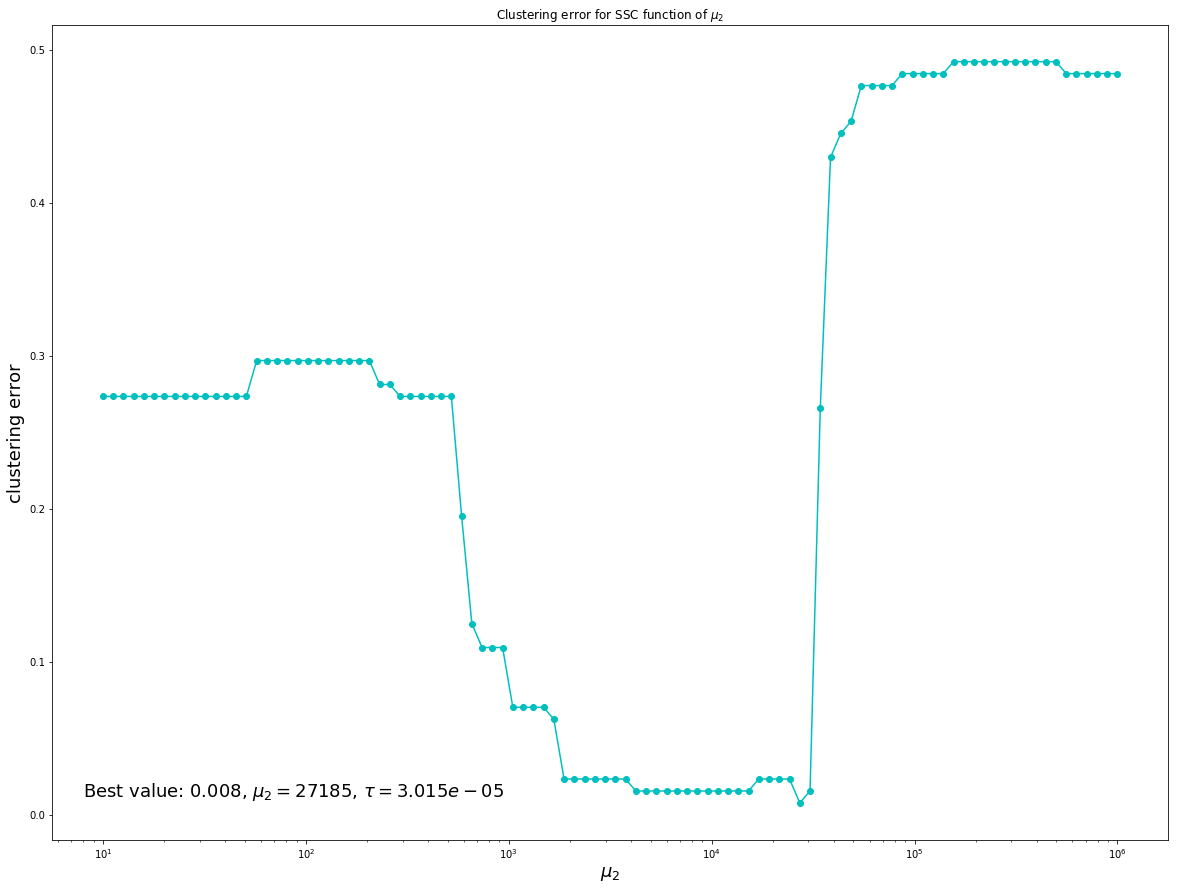

In [139]:
l = []
mu2s = np.logspace(1, 6, num=100)
for mu2 in mu2s:
    pred_labels12_ssc = ssc(ind12_data, 2, tau_min, mu2)
    l.append(clustering_error(ind12_labels, pred_labels12_ssc))

plt.figure(figsize=(20,15))
plt.plot(mu2s, l, '-co')
plt.ylabel('clustering error', size=18)
plt.xlabel(r'$\mu_2$', size=18)
plt.title(r'Clustering error for SSC function of $\mu_2$')
txt = r'Best value: %.3f, $\mu_2 = %d$, $\tau = %.3e$' % (min(l), mu2s[np.argmin(l)], tau_min)
plt.text(8,0.012, txt, size=18)
plt.xscale('log')

## SSC best value: $\mu_2 = 27185$, $\tau = 3.015e-5$

### Best parameters

+ Spectral Clustering: $k = 3$, $\sigma = 0.3$
+ k-Subspaces: See mates
+ SSC : $\tau$ = _10 * getTau(data.T)_ and $\mu_2 = 27185$

### Remi k-Subspaces

In [322]:
from sklearn.utils.extmath import randomized_svd
from scipy.linalg import qr

class Ksubspaces_v1:

    def ortho_matrix(self, D, d):
#         H = np.random.randn(D, D)
#         Q, R = qr(H)
#         return Q[:, :d]
        return np.linalg.svd(np.random.randn(D, d), False)[0]

    
        
    def init_naive(self, X, n):
        N, D = X.shape
        P = X[np.random.choice(N, n, False)]
        return P
    
    # Gaussian initialization
    def init_gaussian(self, X, n):
        
        mu = np.mean(X, axis=0)
        sigma = np.cov(X.T)
        P = np.random.multivariate_normal(mu, sigma, n)
        
        return P
    
    # Kmeans++ initialization
    def init_kmeanspp(self, X, n):
        (N, d) = X.shape
        P = np.empty((n, d))
        P[0] = X[np.random.randint(0, N)]

        D = math.inf * np.ones(N)

        for i in range(n - 1):
            T = X - P[i]
            D = np.minimum(D, np.sum(T * T, axis=1))

            W = D.cumsum()

            z = np.random.uniform(0, W[-1])
            j = np.searchsorted(W > z, True)
            P[i + 1] = X[j]

        return P
    
    
    
    def __init__(self, X, d, max_iter=100, restarts=1):
        
        H_best = math.inf
        for i in range(restarts):
            (mu, U, Y, H, n_iter) = self.run(X, d, max_iter)
            if (H < H_best):
                H_best = H
                self.mu = mu
                self.U = U
                self.Y = Y
                self.H = H
                self.n_iter = i

    def _assign(self, X, mu, U, d):
        N, D = X.shape

        W = np.empty((len(d), N))
        for i in range(len(d)):
            
            Xc = X - mu[i]
            R = Xc - np.dot(np.dot(Xc, U[i]), U[i].T)
            W[i] = np.sum(R * R, axis=-1)
                        
        Y = np.argmin(W, axis=0)
        J = np.sum(np.min(W, axis=0))
            
        return (Y, J)
        
    def run(self, X, d, max_iter=100):
        N, D = X.shape

        #Initialization
        U = [self.ortho_matrix(D, di) for di in d]
#         U  = [np.linalg.svd(np.random.randn(D, di), False)[0] for di in d]
        mu = self.init_naive(X, len(d))
        #mu = self.init_gaussian(X, len(d))

        for i in range(max_iter):
            # Segmentation
            (Y, J) = self._assign(X, mu, U, d)

            #Estimation
            for j in range(len(d)):
                mu[j] = np.mean(X[Y == j], axis=0)
                R = (X[Y == j, :] - mu[j])
                # Uj, _, _ =  np.linalg.svd(R.T, full_matrices=False)
                #U[j] = Uj[:, :d[j]]
                U[j], _, _ =  randomized_svd(R.T, d[j])

        Y, J = self._assign(X, mu, U, d)
        
        return (mu, U, Y, J, i)

## Plot curves for growing number of individuals

In [323]:
individuals = [2, 5, 10, 15, 20, 30, 38]
sc_hist = []
ssc_hist = []
ksub_hist = []

for ind in individuals:
    print(ind)
    # get individuals
    mask_ind, = np.where(np.logical_and(extendedYaleB['EYALEB_LABEL'][0,:] >= 1,
              extendedYaleB['EYALEB_LABEL'][0,:] <= ind) == True)
    ind_data = extendedYaleB['EYALEB_DATA'][:,mask_ind].astype(np.float32)
    ind_labels = extendedYaleB['EYALEB_LABEL'][:,mask_ind].reshape(-1)
    
    # Spectral Clustering
    Xp = ind_data / np.linalg.norm(ind_data, axis=0)
    Aff = gaussian_knn_affinity(Xp.T, 3, 0.3) # k-NN = 3, sigma = 0.3
    pred_labels = spectralClustering(Aff, ind)
    sc_hist.append(clustering_error(ind_labels, pred_labels))
    print('end SC')
    
    # SSC
    tau = 10 * getTau(ind_data.T)
    pred_labels_ssc = ssc(ind_data, ind, tau, 27185)
    ssc_hist.append(clustering_error(ind_labels, pred_labels_ssc))
    print('end SSC')
    
    # k-Subspaces
    ksub = Ksubspaces_v1(ind_data.T, 3 * np.ones(ind, dtype=int), restarts=10)
    ksub_hist.append(clustering_error(ind_labels, ksub.Y))
    print('end k-Sub')
    

# plot
plt.figure(figsize=(20,15))
plt.plot(individuals, sc_hist, '-bo', label="Spectral Clustering")
plt.plot(individuals, ssc_hist, '-ro', label="SSC")
plt.plot(individuals, ksub_hist, '-go', label="k-Subspaces")
plt.xlabel('Number of visages', size=18)
plt.ylabel('Clustering error', size=18)
plt.title('Clustering error function of the number of visages', size=22)
plt.legend()

2
end SC
end SSC
end k-Sub
5
end SC
end SSC
end k-Sub
10
end SC
end SSC
end k-Sub
15
end SC
end SSC
end k-Sub
20
end SC
end SSC
end k-Sub
30
end SC


KeyboardInterrupt: 

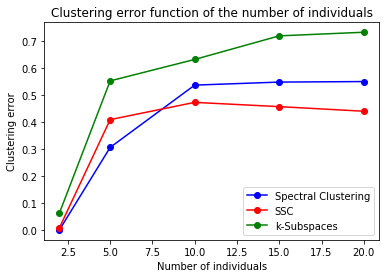

In [335]:
# plot
plt.figure()
plt.plot(individuals[:5], sc_hist[:5], '-bo', label="Spectral Clustering")
plt.plot(individuals[:5], ssc_hist[:5], '-ro', label="SSC")
plt.plot(individuals[:5], ksub_hist[:5], '-go', label="k-Subspaces")
plt.xlabel('Number of individuals')
plt.ylabel('Clustering error')
plt.title('Clustering error function of the number of individuals')
plt.legend()

## 3. Motion Segmentation

In [264]:
import os
import glob
import scipy.io

In [296]:
sc_errors = []
ssc_errors = []

src_dir = 'Hopkins155'
for elt in os.listdir(src_dir):
    if os.path.isdir(os.path.join(src_dir, elt)):
        mat = scipy.io.loadmat(glob.glob(os.path.join(src_dir, elt, "*.mat"))[0])
        labels = mat['s'].reshape(-1)
        n = int(max(mat['s']))
        N = mat['x'].shape[1]
        F = mat['x'].shape[2]
        D = 2 * F
        X = np.transpose(mat['x'][:2,:,:], (2, 0, 1)).reshape(D, N)
    
    
        # Spectral Clustering
        Xp = X / np.linalg.norm(X, axis=0) # need to normalize X if use Remi's gaussian knn affinity
        Aff = gaussian_knn_affinity(Xp.T, 8, 1) # k-NN = 8, sigma = 1
        sc_errors.append(clustering_error(labels, spectralClustering(Aff, n)))
        
        # SSC
        tau = 10 * getTau(X.T)
        mu2 = 800
        pred_labels_ssc = ssc(X, n, tau, mu2)
        ssc_errors.append(clustering_error(labels, pred_labels_ssc))

In [297]:
print(np.mean(sc_errors))
print(np.median(sc_errors))
print(np.std(sc_errors))

0.204819595702
0.203914829407
0.172113794143


In [298]:
print(np.mean(ssc_errors))
print(np.median(ssc_errors))
print(np.std(ssc_errors))

0.186347561079
0.162857142857
0.161512520779
